# Knight Switch Game Integer Linear Program

## Setup/environment configuration

In [1]:
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.9 MB 4.4 MB/s 


In [2]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir(os.path.join(os.getcwd(), 'drive','MyDrive', 'Colab Notebooks', 'gurobi'))

Mounted at /content/drive


In [3]:
import gurobipy as gp
from gurobipy import GRB
with open('gurobi.lic', 'r') as f:
    lic = f.readlines()

WLSACCESSID = lic[-3].replace('\n', '').replace('WLSACCESSID=', '')
WLSSECRET = lic[-2].replace('\n', '').replace('WLSSECRET=', '')
LICENSEID = int( lic[-1].replace('\n', '').replace('LICENSEID=', '') )

e = gp.Env(empty=True)
e.setParam('WLSACCESSID', WLSACCESSID)
e.setParam('WLSSECRET', WLSSECRET)
e.setParam('LICENSEID', LICENSEID)
e.start()

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 889498
Academic license - for non-commercial use only - registered to klt45@cornell.edu


<gurobipy.Env, Parameter changes: WLSAccessID=(user-defined), WLSSecret=(user-defined), LicenseID=889498>

# Let's make some cool visualizations

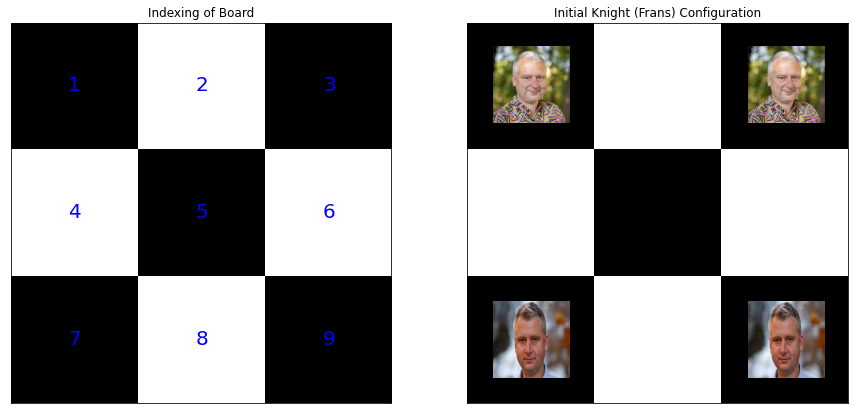

In [4]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def createBoard():
    dx, dy = (0.015, 0.015)
    x = np.arange(0, 3, 0.015)
    y = np.arange(0, 3, 0.015)
    extent = (np.min(x), np.max(x), np.min(y), np.max(y))
    return np.add.outer(range(3), range(1,4)) % 2, extent

z1, extent = createBoard()
coordinateMap = {
    1: (0.5, 2.5), 2: (1.5, 2.5), 3: (2.5, 2.5),
    4: (0.5, 1.5), 5: (1.5, 1.5), 6: (2.5, 1.5),
    7: (0.5, 0.5), 8: (1.5, 0.5), 9: (2.5, 0.5),
}
white = plt.imread('dad.png')
black = plt.imread('father.jpeg')
def plotDad(x, y, ax, w=True):
    ax.imshow(white if w else black, extent=[x-0.3, x+0.3, y-0.3, y+0.3], alpha=1, zorder=1)

def boardLayout():
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    for num, (x,y) in coordinateMap.items():
        ax[0].text(x, y, str(num), ha='center', va='center', fontsize=20, color='blue')
    ax[0].imshow(z1, extent=extent, cmap='binary', interpolation='nearest', alpha=1)
    plotDad(*coordinateMap[1], ax[1])
    plotDad(*coordinateMap[3], ax[1])
    plotDad(*coordinateMap[7], ax[1], w=False)
    plotDad(*coordinateMap[9], ax[1], w=False)
    ax[1].imshow(z1, extent=extent, cmap='binary', interpolation='nearest', alpha=1)
    for i in range(2):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    ax[0].set_title('Indexing of Board')
    ax[1].set_title('Initial Knight (Frans) Configuration')
    plt.show()

boardLayout()

# Problem Statement
Consider a 3x3 chessboard with the above indexing (pictured to the left).  Next, suppose we have the configuration with two white knights, and two black knights (pictured to the right).  Unfortunately, I was unable to draw the knights on the board, so I drew Professor Frans instead since he is my knight in shining armor.  Let the *smiling Frans* represent the white pieces (at positions 1 and 3), and the *serious Frans* represent the black pieces (at positions 7 and 9). We want to swap the white pieces with the dark pieces with the minimum number of L-shaped moves.  **Most importantly**, we will impose the constraint that one piece can occupy one position on the board at a time.  This rules out the naive solution of 8 moves.

# Integer Linear Programmming Formulation

$ x_{src,dst} = \begin{cases} 1 & \text{if there is a transition from state src to state dst} \\ 0 & \text{otherwise} \end{cases} $

## Functions/Parameters:

$ pos(src,dst) = \begin{cases} 1 & \text{if there is a possible/valid knight move from src to dst} \\ 0 & \text{otherwise} \end{cases} $

$ f(state) = \begin{cases} 1 & \text{if state is the source state} \\ -1 & \text{if state is the sink state} \\ 0 & \text{otherwise} \end{cases} $

## Objective and Constraints: 

Let $S$ denote the set of all possible **states**.  Each element of $S$ is a vector in $\mathbb{R}^{4}$ where $(k_1, k_2, k_3, k_4)$ represents the white knights at index $k_1, k_2$ such that $1 \leq k_1 < k_2 \leq 9$
and the black knights in index $k_3, k_4$ such that $1 \leq k_3 < k_4 \leq 9$.  Our objective is to minimize the cost of the network flow such that the $\text{outflow} - \text{inflow} = \text{net flow at state} \ s, \forall s \in S $.  In terms of this problem, our solution will minimize the number of moves it takes to transition from state $(1,3,7,9)$ to $(7,9,1,3)$.

<br> 

$ \min \sum\limits_{ (src,dst)\in S \\ | \text{pos(src,dst)} = 1} x_{src,dst} \\ \text{s.t} $


<br>

$ \sum\limits_{dst \in S \\ | \text{pos(src,dst)} = 1} x_{src,dst} \ - \sum\limits_{dst \in S \\ | \text{pos(dst,src)} = 1} x_{dst,src} = f(src) \quad \forall src \in S $

# Generating all possible states (with preprocessing to account for symmetry)



In [5]:
def generateStates():
    states = {}
    positions = list(i for i in range(1,10) if i!= 5)
    index = 1
    for i in positions:
        for j in positions:
            for k in positions:
                for l in positions:
                    if i not in (j,k,l) and j not in (k,l) and k != l and i < j and k < l:
                        states[index] = (i,j,k,l)
                        index += 1
    return states
len(generateStates())

420

# Defining `possible(src,dst)` to determine which state transitions are feasible

In [6]:
def isKnightMove(source, destination):
    mapping = {1: (6, 8), 2: (7, 9), 3: (4, 8), 4: (3, 9), 5: (), 6: (1, 7), 
               7: (2, 6), 8: (1, 3), 9: (2, 4)}
    return destination in mapping[source]

def possible(src, dst):
    """
    possible that src can transition to dst iff either (1) only one entry is different OR 
    (2) two entries are different are the different entries are due to sorting 
    (it's technical one different entry, but we sort in ascending order) AND
    the different entry is a knight move
    """
    diff = [i for i in range(4) if src[i] != dst[i]]
    if len(diff) == 1:
        return isKnightMove(source=src[diff[0]], destination=dst[diff[0]])
    elif len(diff) == 2 and (diff == [0,1] or diff == [2,3]):
        nodes, freqs = list(zip(*
            Counter( (src[diff[0]], src[diff[1]], dst[diff[0]], dst[diff[1]]) ).most_common()
                    ))
        if freqs[0] == 2:
            return isKnightMove(source=nodes[1], destination=nodes[2])
        return False
    return False

assert possible( (1,3,7,9), (7,9,1,3) )  == False
assert possible( (1,3,7,9), (1,8,7,9) )  == True
assert possible( (1,3,7,9), (1,3,4,7) )  == True
assert possible( (1,3,7,9), (3,6,7,9) )  == True
assert possible( (1,3,7,9), (1,3,7,9) )  == False
print('All test cases passed, possible(src, dst) implementation is correct')

All test cases passed, possible(src, dst) implementation is correct


# Results: The minimum number of moves is 16 and the total solving time takes 0.10 seconds

In [7]:
def f(s):
    """returns the flow at state s"""
    if s == (1,3,7,9): # source
        return 1
    elif s == (7,9,1,3): # sink
        return -1
    return 0

model = gp.Model("knight", env=e)

S = generateStates()

# Let x_(src, dst) be 1 if there's a transition from state src to dst and 0 otherwise

x = model.addVars( [ (src, dst) for src in S for dst in S if possible(S[src], S[dst]) ], 
                    vtype=GRB.BINARY, name="x")


for src in S:
    model.addConstr( gp.quicksum(x[src, dst] for dst in S if possible(S[src], S[dst])) - 
                     gp.quicksum(x[dst, src] for dst in S if possible(S[dst], S[src])) 
                     == f(S[src]) 
                   )

model.setObjective( gp.quicksum(x[s, s_] for s in S for s_ in S if possible(S[s], S[s_])) , GRB.MINIMIZE)

model.optimize()

print('Optimal value:', model.objVal)

adjacencyList = {}

for v in model.getVars():
    if v.x > 0:
        indices = v.varName.replace('x', '').replace('[', '').replace(']', '').split(',')
        adjacencyList[S[int(indices[0])]] = S[int(indices[1])]
  
start = (1,3,7,9)
path = [start]
while path[-1] in adjacencyList: #should end at (7,9,1,3):
    path.append(adjacencyList[path[-1]])
    print(path[-2], '→', path[-1])

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to klt45@cornell.edu
Optimize a model with 420 rows, 1920 columns and 3840 nonzeros
Model fingerprint: 0x6bcf8045
Variable types: 0 continuous, 1920 integer (1920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 82.0000000
Presolve removed 140 rows and 640 columns
Presolve time: 0.03s
Presolved: 280 rows, 1280 columns, 2560 nonzeros
Variable types: 0 continuous, 1280 integer (1280 binary)

Root relaxation: objective 1.600000e+01, 270 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Ob

# Visualizing the 16 moves

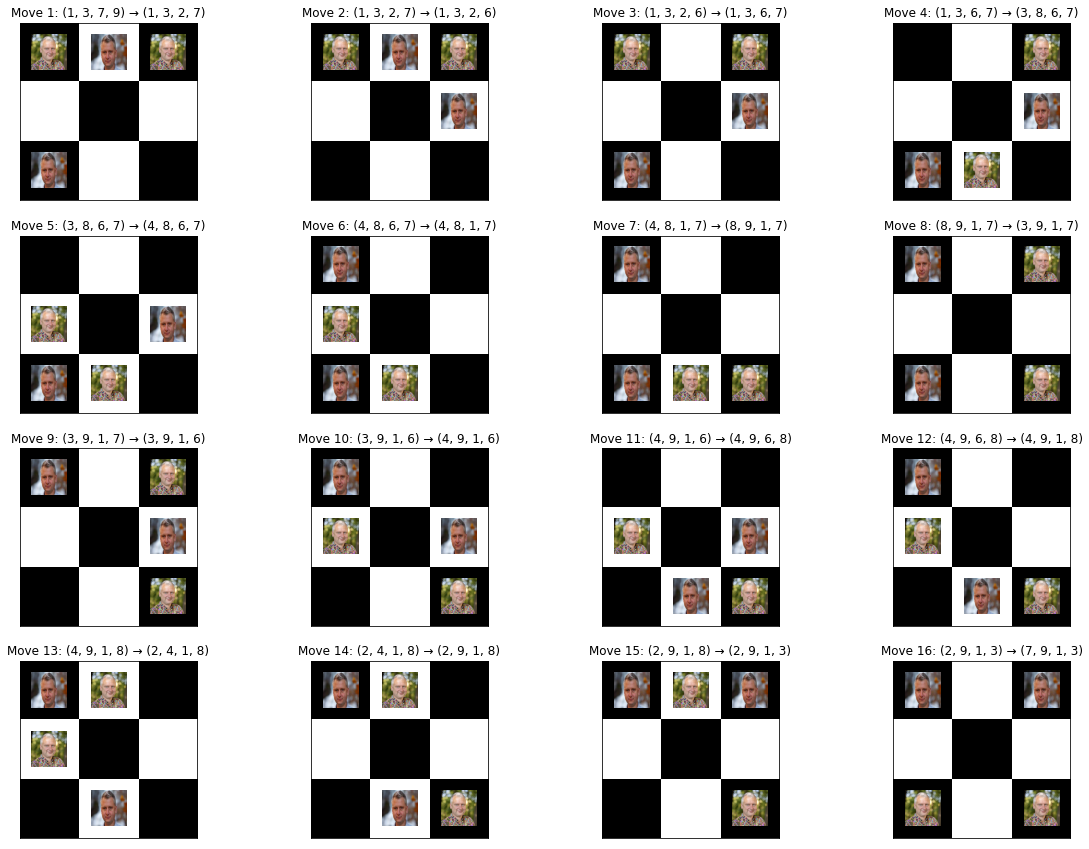

In [8]:
def solution():
    fig, ax = plt.subplots(4, 4, figsize=(20, 15))
    ax = ax.flatten()
    for i, (k1, k2, k3, k4) in enumerate(path[1:]):
        plotDad(*coordinateMap[k1], ax[i])
        plotDad(*coordinateMap[k2], ax[i])
        plotDad(*coordinateMap[k3], ax[i], w=False)
        plotDad(*coordinateMap[k4], ax[i], w=False)
        ax[i].imshow(z1, cmap='binary', interpolation='nearest', extent=extent, alpha=1)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(f'Move {i+1}: {path[i]} → {path[i+1]}')
    plt.show()

solution()